<a href="https://colab.research.google.com/github/yovelop/NN/blob/master/NN_Energy_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DIR = '/content/drive/My Drive/Colab Notebooks/ENSaver/'

In [0]:
#Импорты
if 1==1:
  import numpy as np # linear algebra
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

  import matplotlib.pyplot as plt
  import matplotlib.style
  matplotlib.style.use('ggplot')

  from sys import getsizeof

  import os
  for dirname, _, filenames in os.walk(DIR):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  pd.options.mode.chained_assignment = None  # default='warn'
  import warnings
  pd.set_option('display.max_rows', 500)
  pd.set_option('display.max_columns', 500)
  pd.set_option('display.width', 100)
  warnings.filterwarnings('ignore')
  np.set_printoptions (precision = 4, suppress  = True)

  def reduce_mem_usage(df):
      start_mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage of properties dataframe is :",start_mem_usg," MB")
      NAlist = [] # Keeps track of columns that have missing values filled in. 
      for col in df.columns:
          if df[col].dtype != object:  # Exclude strings            
              # Print current column type
              print("******************************")
              print("Column: ",col)
              print("dtype before: ",df[col].dtype)            
              # make variables for Int, max and min
              IsInt = False
              mx = df[col].max()
              mn = df[col].min()
              print("min for this col: ",mn)
              print("max for this col: ",mx)
              # Integer does not support NA, therefore, NA needs to be filled
              if not np.isfinite(df[col]).all(): 
                  NAlist.append(col)
                  df[col].fillna(mn-1,inplace=True)  
                    
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = (df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)
              
              # Print new column type
              print("dtype after: ",df[col].dtype)
              print("******************************")
      # Print final result
      print("___MEMORY USAGE AFTER COMPLETION:___")
      mem_usg = df.memory_usage().sum() / 1024**2 
      print("Memory usage is: ",mem_usg," MB")
      print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
      return df, NAlist

  def show_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.show()
    
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([1,2])
    plt.legend(['Train','Val'])
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0,1])
    plt.legend(['Train','Val'])
    plt.show()

/content/drive/My Drive/Colab Notebooks/ENSaver/building_metadata.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/model_nn.h5
/content/drive/My Drive/Colab Notebooks/ENSaver/model_nn.json
/content/drive/My Drive/Colab Notebooks/ENSaver/out_file_int.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/sample_submission (1).csv
/content/drive/My Drive/Colab Notebooks/ENSaver/sample_submission.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/test.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/train.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/weather_test.csv
/content/drive/My Drive/Colab Notebooks/ENSaver/weather_train.csv


In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater

#  Подготовка данных
if 1==1:
  df = pd.read_csv(DIR + "train.csv", engine = 'python')
  #df_test = pd.read_csv(DIR + "test.csv", engine = 'python')

  df['timestamp'] = pd.to_datetime(df['timestamp'])
  #df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

  #Очистка от корявых данных
  #df = df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

  #df['meter_reading'] = np.log1p(df['meter_reading'])

  #df = pd.concat([df_train, df_test], sort=False)

  df['hour_cos'] = np.cos(df['timestamp'].dt.hour * 2 * np.pi / 24)
  df['hour_sin'] = np.sin(df['timestamp'].dt.hour * 2 * np.pi / 24)

  df['weekday_cos'] = np.cos(df['timestamp'].dt.weekday * 2 * np.pi / 7)
  df['weekday_sin'] = np.sin(df['timestamp'].dt.weekday * 2 * np.pi / 7)

  df['week_cos'] = np.cos(df['timestamp'].dt.week * 2 * np.pi / 53)
  df['week_sin'] = np.sin(df['timestamp'].dt.week * 2 * np.pi / 53)

  #df_train['weekends'] = (df_train['weekday'] >= 6) * 1

In [0]:
#Очистка от подозрительных нулей
if 1==1:
  #print(df[df['building_id']==2][['timestamp','meter_reading','meter','ds_zero','de_zero','is_bad_zero']].head(20))

  df = df.sort_values(by = ['meter','building_id','timestamp'])
  df['meter_reading_prev'] = 0

  #for bid in df['building_id'].unique():
  #  for met in df['meter'].unique():
  df['meter_reading_prev'] = df['meter_reading'].shift()
  df['is_equal_prev']= (df['meter_reading_prev'] == df['meter_reading'] )*1

  df['day'] = df['timestamp'].dt.dayofyear
  df_bad_rows = df.groupby(by=['building_id','day','meter'], as_index = False)['is_equal_prev'].mean()
  df_bad_rows.rename({"is_equal_prev": "IS_BAD_PRCNT"}, axis='columns', inplace=True)

  df = pd.merge(df, df_bad_rows, how = 'inner', on = ['building_id','day','meter'])
  #print(df_bad_rows[df_bad_rows['building_id']==109].head(365))
  del df_bad_rows 

  #print(df[df['building_id']==2][['timestamp','meter_reading','is_equal_prev','IS_BAD_PRCNT','day']].head(30))

In [0]:
# Добавление медианы по метрике постройки
if 1==1:
  df_median = df.groupby(by=['building_id','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','meter'])
  del df_median 

# Добавление медианы по часу, по неделе, метрике постройки
if 1==1:
  df['hour'] = df['timestamp'].dt.hour
  df_median = df.groupby(by=['building_id','hour','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_hour_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','hour','meter'])
  del df_median 

  df['weekday'] = df['timestamp'].dt.weekday
  df_median = df.groupby(by=['building_id','weekday','meter'])['meter_reading'].median()
  df_median.name = 'building_meter_weekday_median'
  df = pd.merge(df, df_median, how = 'inner', on = ['building_id','weekday','meter'])
  del df_median 

#Подстановка параметров сооружения
if 1==1:
  building_df = pd.read_csv(DIR + "building_metadata.csv", engine = 'python')
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  building_df["primary_use_ID"] = le.fit_transform(building_df["primary_use"])

  building_df['primary_use'] = building_df['primary_use'].astype('category')
  building_df = pd.get_dummies(building_df)

  df = df.merge(building_df, left_on = "building_id", right_on = "building_id", how = "left")
  df.head(5)
  del building_df

In [0]:
#Вставка данных погоды
#Восстановление пустых данных погоды через соседей по линейной инетрполяции
if 1==1:
  df_weather = pd.read_csv(DIR + "weather_train.csv", engine = 'python')
  df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
  #weather_train.groupby('site_id').apply(lambda group: group.isna().sum())
  df_weather = df_weather.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
  df = pd.merge(df, df_weather, how = 'left', on = ['site_id','timestamp'])
  del df_weather

In [0]:
#Инфо о корявости данных:
if 1==1:
  print('0 Всего:',df[df['meter']==0].shape, 'Откинуть:', df[(df['meter']==0) & (df['IS_BAD_PRCNT']>0.45)].shape)
  print('1 Всего:',df[df['meter']==1].shape, 'Откинуть:', df[(df['meter']==1) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('2 Всего:',df[df['meter']==2].shape, 'Откинуть:', df[(df['meter']==2) & (df['IS_BAD_PRCNT']>0.75)].shape)
  print('3 Всего:',df[df['meter']==3].shape, 'Откинуть:', df[(df['meter']==3) & (df['IS_BAD_PRCNT']>0.75)].shape)

0 Всего: (12060910, 47) Откинуть: (1401057, 47)
1 Всего: (4182440, 47) Откинуть: (537615, 47)
2 Всего: (2708713, 47) Откинуть: (223436, 47)
3 Всего: (1264037, 47) Откинуть: (311410, 47)


In [0]:
#Вывести кол-во пустот по полям. Затем заполнить из средним значением по полю

for col in df.columns:
  print(col)
  for met in df['meter'].unique():
    if np.sum(df[col].isnull()) > 0:
      print(met)
      print(np.sum(df[col].isnull()))

      df_col = df.groupby(by=['building_id','meter'], as_index = False)[col].mean()
      df_col.rename({col: "tmp"}, axis='columns', inplace=True)
      df = df.merge(df_col, left_on = ['building_id','meter'], right_on = ['building_id','meter'], how = "left")
      df[col].fillna( df_col['tmp'], inplace = True)
      df.drop(columns = ['tmp'],inplace = True)
      del df_col

      df_col = df.groupby(by=['meter'], as_index = False)[col].mean()
      df_col.rename({col: "tmp"}, axis='columns', inplace=True)
      df = df.merge(df_col, left_on = ['meter'], right_on = ['meter'], how = "left")
      df[col].fillna( df_col['tmp'], inplace = True)
      df.drop(columns = ['tmp'],inplace = True)
      del df_col

      df[col].fillna( df[col].mean(), inplace = True)


In [0]:
df.to_pickle(DIR + 'DF_TRAIN_EXTENDED.PKL')

In [28]:
df.describe()

,building_id,meter,meter_reading,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin,meter_reading_prev,is_equal_prev,day,IS_BAD_PRCNT,building_meter_median,hour,building_meter_hour_median,weekday,building_meter_weekday_median,site_id,square_feet,year_built,floor_count,primary_use_ID,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03,-4.446777e-05,-1.742977e-04,-3.437434e-03,-3.212597e-03,-2.217928e-02,-1.218814e-02,2.117121e+03,1.642751e-01,1.854788e+02,1.642751e-01,3.591544e+02,1.150232e+01,3.675371e+02,3.006958e+00,3.619454e+02,7.992232e+00,1.077830e+05,1.968277e+03,4.184843e+00,3.157800e+00,4.039109e-01,1.120353e-01,5.643522e-03,1.971335e-02,1.061734e-01,6.218460e-03,2.173943e-01,1.198164e-02,1.057553e-02,8.225256e-02,1.600754e-03,5.572638e-03,4.774363e-03,3.839860e-03,2.780111e-03,5.533263e-03,1.598786e+01,2.750540e+00,7.747271e+00,1.253409e+00,1.016067e+03,1.712142e+02,3.375851e+00
std,4.269133e+02,9.309921e-01,1.532356e+05,7.070684e-01,7.071452e-01,7.068351e-01,7.073628e-01,7.036120e-01,7.101336e-01,1.532356e+05,3.705250e-01,1.052632e+02,3.151920e-01,1.562534e+03,6.922017e+00,1.574370e+03,1.997191e+00,1.570868e+03,5.099060e+00,1.171424e+05,1.910769e+01,1.669545e+00,3.450774e+00,4.906800e-01,3.154099e-01,7.491110e-02,1.390134e-01,3.080595e-01,7.861164e-02,4.124730e-01,1.088029e-01,1.022922e-01,2.747491e-01,3.997739e-02,7.444181e-02,6.893162e-02,6.184752e-02,5.265341e-02,7.417982e-02,1.092282e+01,2.720162e+00,1.015547e+01,8.067542e+00,6.901617e+00,1.125127e+02,2.258985e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-9.009689e-01,-9.749279e-01,-9.982437e-01,-9.995608e-01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,-7.071068e-01,-7.071068e-01,-9.009689e-01,-7.818315e-01,-7.175073e-01,-7.378333e-01,1.830000e+01,0.000000e+00,9.600000e+01,0.000000e+00,2.200000e+01,6.000000e+00,2.283650e+01,1.000000e+00,2.264000e+01,3.000000e+00,3.252700e+04,1.968277e+03,4.184843e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.900000e+00,0.000000e+00,3.000000e-01,0.000000e+00,1.011800e+03,8.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,-1.836970e-16,0.000000e+00,-2.225209e-01,0.000000e+00,-8.879590e-02,-5.924063e-02,7.877500e+0

In [0]:
#Импорты Керас:
if 1==1:
  from keras.models import Sequential

  from keras.layers import Dense
  from keras.initializers import TruncatedNormal, Constant
  from keras.regularizers import l1
  from keras.optimizers import Adam
  import keras.backend as K

  from keras. callbacks import EarlyStopping, ReduceLROnPlateau
  #from keras.utils import plot_model
  from keras.losses import mean_squared_error as mse #, mean_absolute_percentage_error as mape

  def RMSLE(y_true, y_pred):
    return K.pow( K.mean( K.pow(K.log(y_true+1) - K.log(y_pred+1),2.00000)),0.5000)

  def tweedieloss(y_true, y_pred):
      return K.mean(  K.pow(    K.pow(backend.maximum(0.000,K.maximum(0.013000,y_true)),0.5)  -   K.pow(K.maximum(0.013000,y_pred),0.5)   , 2 ) / K.pow(K.maximum(0.013000,y_pred),0.5)
                  )

  def tweedieloss_bkp(y_true, y_pred):
      p=1.5
      dev = 2 * (K.pow(K.maximum(0.000,y_true), 2-p)/((1-p) * (2-p)) -
                    y_true * K.pow(y_pred, 1-p)/(1-p) +
                    K.pow(y_pred, 2-p)/(2-p))
      return K.mean(dev)

  def VAL_ (y_true, y_pred):
      return  K.maximum(0.0330000, K.sum(y_pred))/ K.maximum(0.033000, K.sum(y_true)) 
      
  def VAL_2 (y_true, y_pred):
      return  K.exp ( K.abs( K.log( VAL_ (y_true, y_pred))))-1
      
  def MAPE_ (y_true, y_pred):
      return K.mean( K.minimum( 5.000000,  K.abs(y_true - y_pred)/ K.maximum(0.033000, y_true)) )
      
  def MAE_(y_true, y_pred):
      return K.sum( K.abs(y_true - y_pred))/ K.maximum(0.033000, K.sum(y_true))

  def MSE_(y_true, y_pred):
      return K.sum( K.pow(y_true - y_pred,2.00000))/ K.maximum(0.033000,  K.sum(K.pow(y_true,2.00000)))

  def MAE_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          +  0.250000 * MAPE_ (y_true, y_pred)
      )
              
  def MAE_VAL_MAPE(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 1.800000 *   VAL_2 (y_true, y_pred)          
          + 0.950000 *   MAPE_ (y_true, y_pred)
          )

  def MAE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)
          + 0.800000 *   VAL_2 (y_true, y_pred)                     
              )

  def MAPE_VAL(y_true, y_pred):
      return (
                      MAPE_ (y_true, y_pred)
          + 0.4000 *  VAL_2 (y_true, y_pred)             
              )

  def MSE_VAL_MAPE(y_true, y_pred):
      return (
            5.000000 *   MSE_(y_true, y_pred)
          + 2.200000 *   VAL_2 (y_true, y_pred)          
          + 0.750000 *   MAPE_ (y_true, y_pred)
          )

  def MASPE_VAL(y_true, y_pred):
      return (
                        MAE_(y_true, y_pred)               
          + 0.500000 *   MSE_(y_true, y_pred)
          + 1.200000 *   VAL_2 (y_true, y_pred)          
          + 0.250000 *   MAPE_ (y_true, y_pred)
          )
  
  def MAE_RMSLE(y_true, y_pred):
      return (
            1.000000 *   MAE_   (y_true, y_pred)
          + 2.000000 *   RMSLE  (y_true, y_pred)          
          )  

  import keras.metrics
  keras.metrics.MAE_ = MAE_
  keras.metrics.VAL_ = VAL_
  keras.metrics.VAL_2 = VAL_2
  keras.metrics.MAPE_ = MAPE_
  keras.metrics.MSE_ = MSE_
  keras.metrics.tweedieloss = tweedieloss

  import keras.losses
  keras.losses.MAE_VAL_MAPE = MAE_VAL_MAPE
  keras.losses.MSE_VAL_MAPE = MSE_VAL_MAPE
  keras.losses.MAE_ = MAE_
  keras.losses.MASPE_VAL = MASPE_VAL
  keras.losses.tweedieloss = tweedieloss

Using TensorFlow backend.


In [0]:
df.columns

In [0]:
Out_Columns = 'meter_reading'
In_Columns = [ 'hour_cos','hour_sin', 'weekday_cos', 'weekday_sin', 'week_cos', 'week_sin',
       'site_id', 'square_feet', 'year_built', 'floor_count', #'primary_use_ID',
       'primary_use_Education', 'primary_use_Entertainment/public assembly',
       'primary_use_Food sales and service', 'primary_use_Healthcare',
       'primary_use_Lodging/residential',
       'primary_use_Manufacturing/industrial', 'primary_use_Office',
       'primary_use_Other', 'primary_use_Parking',
       'primary_use_Public services', 'primary_use_Religious worship',
       'primary_use_Retail', 'primary_use_Services',
       'primary_use_Technology/science', 'primary_use_Utility',
       'primary_use_Warehouse/storage', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'
       , 'building_meter_median','building_meter_hour_median','building_meter_weekday_median']
# Нормализация
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
scaler =  MinMaxScaler (copy=True, feature_range=(0, 1))                                  #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
scaler.fit( df[In_Columns] )
df[In_Columns]     = pd.DataFrame(data = scaler.transform( df[In_Columns])    , columns = df[In_Columns].columns   , index=Train.index) 

df.fillna(0.33)

In [0]:
#0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# РАСЧЁТ НЕЙРОНОК:
if 1==1:
  reg = 0.00001
  batch_size = 2048
  epochs = 50

  earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min')
  reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')

  init = TruncatedNormal(mean=0.0, stddev=0.05, seed=159)
  bias = Constant(value = 1e-3)

  opt = Adam(lr = 0.003)
  
  if 0==0:
    meter = 0
    
    nn_0 = Sequential()
    nn_0.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_0.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_0.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_0.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse' ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_0.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                    , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 

  if 1==1:
    meter = 1
    
    nn_1 = Sequential()
    nn_1.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_1.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_1.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_1.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse' ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_1.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                    , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
  if 2==2:
    meter = 2
    
    nn_2 = Sequential()
    nn_2.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_2.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_2.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_2.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse' ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_2.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                    , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 
  if 3==3:
    meter = 3
    
    nn_3 = Sequential()
    nn_3.add(Dense(60, input_shape = df[In_Columns].shape[1:], activation = 'tanh', kernel_regularizer=l1(reg), kernel_initializer = 'normal'))
    nn_3.add(Dense(60, activation = 'tanh',  kernel_initializer = 'normal'))
    nn_3.add(Dense(1, activation = 'relu', kernel_initializer = 'normal'))

    nn_3.compile(optimizer = opt, loss = MAE_RMSLE, metrics=[ MAE_, RMSLE, VAL_, 'mse' ])
    
    val = df[(df['meter']==meter) & (df['day']%6==0)]
    hist = nn_3.fit( df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][In_Columns], df[(df['meter']==meter) & (df['IS_BAD_PRCNT']<0.45)][Out_Columns], batch_size = batch_size, verbose = 1
                    , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]
                    , validation_data=(val[In_Columns], val[Out_Columns])
                    ) 

Epoch 1/50
10659833/10659833 [==============================] - 34s 3us/step - loss: 81900.6388 - MAE_: 0.5282 - RMSLE: 0.9761 - VAL_: 0.7018
Epoch 2/50
10659833/10659833 [==============================] - 34s 3us/step - loss: 35856.5473 - MAE_: 0.2421 - RMSLE: 0.6937 - VAL_: 0.9077
Epoch 3/50
10659833/10659833 [==============================] - 34s 3us/step - loss: 21748.9692 - MAE_: 0.2014 - RMSLE: 0.7389 - VAL_: 0.9594
Epoch 4/50
10659833/10659833 [==============================] - 34s 3us/step - loss: 15797.0428 - MAE_: 0.1885 - RMSLE: 0.7605 - VAL_: 0.9746
Epoch 5/50
10659833/10659833 [==============================] - 35s 3us/step - loss: 12737.4540 - MAE_: 0.1823 - RMSLE: 0.7570 - VAL_: 0.9825
Epoch 6/50
10659833/10659833 [==============================] - 36s 3us/step - loss: 10898.4781 - MAE_: 0.1786 - RMSLE: 0.7876 - VAL_: 0.9854
Epoch 7/50
10659833/10659833 [==============================] - 36s 3us/step - loss: 9648.3607 - MAE_: 0.1754 - RMSLE: 0.7910 - VAL_: 0.9874
Epoch 8

In [0]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_delta=1e-3, mode='min')

nn.optimizer.lr = nn.optimizer.lr / 2.00000000

hist = nn.fit( df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns], batch_size = batch_size, verbose = 1
                 , epochs = epochs * 2, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss], validation_data=(df[df['meter']==0][In_Columns], df[df['meter']==0][Out_Columns])) 

In [0]:
hist_1 = nn.fit( df[df['meter']==1][In_Columns], df[df['meter']==1][Out_Columns], batch_size = batch_size, verbose = 1
                 , epochs = epochs, shuffle = True, callbacks=[earlyStopping, reduce_lr_loss]) #, validation_data=(X_val, y_val)


                   timestamp  meter_reading  is_equal_prev
19280839 2016-05-20 01:00:00       0.000000              0
19280872 2016-05-20 02:00:00       0.000000              1
19280905 2016-05-20 03:00:00       0.000000              1
19280938 2016-05-20 04:00:00       0.000000              1
19280971 2016-05-20 05:00:00       0.000000              1
19281004 2016-05-20 06:00:00       0.000000              1
19281037 2016-05-20 07:00:00       0.000000              1
19281070 2016-05-20 08:00:00       0.000000              1
19281103 2016-05-20 09:00:00       0.000000              1
19281136 2016-05-20 10:00:00       0.000000              1
19281169 2016-05-20 11:00:00       0.000000              1
19281202 2016-05-20 12:00:00       0.000000              1
19281235 2016-05-20 13:00:00       0.000000              1
19281268 2016-05-20 14:00:00       0.000000              1
19281301 2016-05-20 15:00:00       0.000000              1
19281334 2016-05-20 16:00:00       0.000000             

KeyError: ignored

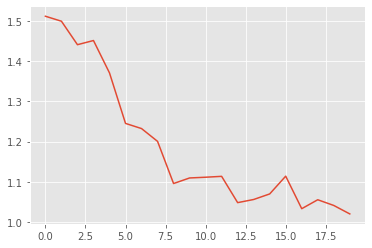

In [0]:
show_plot(hist) 

In [0]:
def save_model(model, dir = os.getcwd(), name = 'model'):
  model_json = model.to_json()
  with open(os.path.join(dir,name+'.json'), 'w') as json_file:
      json_file.write(model_json)
  model.save_weights(os.path.join(dir,name+'.h5'))
  print("Saved model to disk.")

In [0]:
save_model(nn, DIR, 'model_nn')

Saved model to disk.


In [0]:
from keras.models import model_from_json

def load_model(dir = os.getcwd(), name = 'model'):
  json_file = open(os.path.join(dir,name+'.json'), 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  model.load_weights(os.path.join(dir,name+'.h5'))
  print("Loading is complete.")
  return model

In [0]:
nn = load_model(DIR, 'model_nn')
opt = Adam(lr = 0.05)
nn.compile(optimizer = opt, loss = mse)










Loading is complete.



In [0]:
from sklearn.utils import shuffle

In [0]:
k = nn.evaluate(X_val, y_val, batch_size = 800000, verbose = 0)
print(k)
for i in range(X_val.shape[1]):
    X_val_2 = X_val.copy()
    s = shuffle(X_val_2.iloc[:,i])
    s.index = X_val_2.index
    X_val_2.iloc[:, i] = s
    print('{}: {:2.5}'.format(cols[i], nn.evaluate(X_val_2, y_val, batch_size = 800000, verbose = 0) - k))
    X_val_2 = None

0.9596900019018605
building_median: 5.819
meter_0: 0.58292
meter_1: 0.972
meter_2: 0.74869
meter_3: 0.37119
site_id: 0.2405
square_feet: 0.30628
site_id_0: 1.0401
site_id_1: 0.1221
site_id_2: 0.30877
site_id_3: 0.18319
site_id_4: 0.062723
site_id_5: 0.074246
site_id_6: 0.1025
site_id_7: 0.20131
site_id_8: 0.043794
site_id_9: 0.28214
site_id_10: 0.057954
site_id_11: 0.01723
site_id_12: 0.013731
site_id_13: 0.24857
site_id_14: 0.30342
site_id_15: 0.13226
primary_use_Education: 0.3433
primary_use_Entertainment/public assembly: 0.15548
primary_use_Food sales and service: 0.014033
primary_use_Healthcare: 0.061511
primary_use_Lodging/residential: 0.15654
primary_use_Manufacturing/industrial: 0.016794
primary_use_Office: 0.25216
primary_use_Other: 0.017878
primary_use_Parking: 0.03211
primary_use_Public services: 0.11415
primary_use_Religious worship: 0.0012776
primary_use_Retail: 0.0078331
primary_use_Services: 0.018232
primary_use_Technology/science: 0.0096781
primary_use_Utility: 0.0033111

In [0]:
X_test.shape

(41697600, 45)

In [0]:
p = nn.predict(X_test, batch_size = 100000)

In [0]:
df_sample_submission['meter_reading'] = np.exp(p)-1

In [0]:
df_sample_submission.to_csv(DIR+'out_file_int.csv', index = False)

In [0]:
p[0:5]

array([[5.240274 ],
       [5.1473227],
       [5.0696645],
       [5.019961 ],
       [5.010914 ]], dtype=float32)

In [0]:
df_sample_submission.head()

,row_id,meter_reading
8784,0,187.721802
8785,129,170.970444
8786,258,158.120926
8787,387,150.405380
8788,516,149.041794


In [0]:
X_test.head()

,building_median,meter_0,meter_1,meter_2,meter_3,site_id,square_feet,site_id_0,site_id_1,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,site_id_10,site_id_11,site_id_12,site_id_13,site_id_14,site_id_15,primary_use_Education,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,hour_cos,hour_sin,weekday_cos,weekday_sin,week_cos,week_sin
8784,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0.500000,0.801938,0.099031,0.996487,0.440837
8785,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.982963,0.629410,0.801938,0.099031,0.996487,0.440837
8786,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.933013,0.750000,0.801938,0.099031,0.996487,0.440837
8787,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.853553,0.853553,0.801938,0.099031,0.996487,0.440837
8788,0.495495,1,0,0,0,0.0,0.008173,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.750000,0.933013,0.801938,0.099031,0.996487,0.440837


In [0]:
df_sample_submission['row_id'] = df_sample_submission['row_id'].astype('Int32')


In [0]:
df_sample_submission['meter_reading'] = df_sample_submission['meter_reading'].astype('Int32')


In [0]:
# df_group = train_df.groupby('building_id')['meter_reading_log1p']
# building_mean = df_group.mean().astype(np.float16)
# building_median = df_group.median().astype(np.float16)
# building_min = df_group.min().astype(np.float16)
# building_max = df_group.max().astype(np.float16)
# building_std = df_group.std().astype(np.float16)

# train_df['building_mean'] = train_df['building_id'].map(building_mean)
# train_df['building_median'] = train_df['building_id'].map(building_median)
# train_df['building_min'] = train_df['building_id'].map(building_min)
# train_df['building_max'] = train_df['building_id'].map(building_max)
# train_df['building_std'] = train_df['building_id'].map(building_std)

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
scaler =  MinMaxScaler () #quantile_range  = (15.0,85.0)) #Normalizer #(copy=True, feature_range=(-1, 1)) # MinMaxScaler(copy=True, feature_range=(-1, 1)) #StandardScaler() #MinMaxScaler(copy=True, feature_range=(-1, 1)) # RobustScaler()
scaler.fit(df[In_Columns])
df[In_Columns]     = pd.DataFrame(data = scaler_out.transform( df[In_Columns])    , columns = df[In_Columns].columns   , index=Train.index) #X_train.columns)
